In [1]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import os
import sys
import torch
import torch.backends.cudnn as cudnn
import torch.cuda as tcuda
import torch.nn as nn
import yaml

from torch.nn.functional import softmax
from utils import get_data_loader

from sklearn.metrics import (
    auc,
    accuracy_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)
from scipy.stats import pearsonr

from suepvision.smodels import (
    LeNet5,
    get_resnet18,
    get_resnet50
)

hep.style.use("CMS")

In [7]:
config = yaml.safe_load(open("configs/lenet-labframe-classifier.yml"))
dataset = config['dataset']
evaluation_pref = config['evaluation_pref']

In [8]:
MODEL_NAME_1 = 'LeNet5-LabFrame-Double'

model1 = eval(config['architecture'])()
model1.load_state_dict(torch.load("models/{}.pth".format(MODEL_NAME_1)))
model1 = model1.to(0)

MODEL_NAME_2 = 'LeNet5-LabFrame-DoubleB'

model2 = eval(config['architecture'])()
model2.load_state_dict(torch.load("models/{}.pth".format(MODEL_NAME_2)))
model2 = model2.to(0)

In [9]:
test_loader = get_data_loader(
    dataset['test'][0],
    evaluation_pref['batch_size'],
    evaluation_pref['workers'],
    dataset['in_dim'],
    0,
    boosted=dataset['boosted'],
    shuffle=False
)

In [10]:
results_model1 = torch.tensor([])
results_model2 = torch.tensor([])

model1.eval()
model2.eval()

with torch.no_grad():
    for images, targets, _, _ in test_loader:
        
        targets = tcuda.LongTensor(targets, device=0)
        
        outputs1 = model1(images)
        outputs2 = model2(images)
        
        batch_results1 = torch.cat((targets.reshape(-1, 1), outputs1), 1)
        batch_results2 = torch.cat((targets.reshape(-1, 1), outputs2), 1)
        
        results_model1 = torch.cat((results_model1, batch_results1.cpu()), 0)
        results_model2 = torch.cat((results_model2, batch_results2.cpu()), 0)

In [11]:
CV = 10

y_true1 = results_model1[:, 0]
y_true2 = results_model2[:, 0]
y_pred1 = softmax(results_model1[:, 1:], 1)
y_pred2 = softmax(results_model2[:, 1:], 1)
y_pred1 = y_pred1[:, 1].detach().cpu().numpy()
y_pred2 = y_pred2[:, 1].detach().cpu().numpy()

samples_per_cv = len(y_true1) // CV

acc1, acc2, corr = [], [], []
for i in range(CV):
    y_true1_cv = y_true1[i*samples_per_cv:(i+1)*samples_per_cv]
    y_true2_cv = y_true2[i*samples_per_cv:(i+1)*samples_per_cv]
    y_pred1_cv = y_pred1[i*samples_per_cv:(i+1)*samples_per_cv]
    y_pred2_cv = y_pred2[i*samples_per_cv:(i+1)*samples_per_cv]

    acc1.append(accuracy_score(y_true1_cv, y_pred1_cv > .5))
    acc2.append(accuracy_score(y_true2_cv, y_pred2_cv > .5))

    corr.append(pearsonr(y_pred1_cv[y_true1_cv == 0], y_pred2_cv[y_true1_cv == 0])[0])

print(u'Accuracy Model 1: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(acc1), np.std(acc1)))
print(u'Accuracy Model 2: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(acc2), np.std(acc2)))
print(u'Correlation: {0:.3f} \u00B1 {1:.3f}'.format(np.mean(corr), np.std(corr)))

Accuracy Model 1: 0.902 ± 0.002
Accuracy Model 2: 0.890 ± 0.002
Correlation: 0.284 ± 0.018


In [40]:
suep_cl1 = y_pred1[y_true1 == 1]
suep_cl2 = y_pred2[y_true1 == 1]

qcd_cl1 = y_pred1[y_true1 == 0]
qcd_cl2 = y_pred2[y_true1 == 0]

In [41]:
hist_abcd = (
     hist.new
    .Regular(50, 0, 1, name="classifier_output_1", label="Classifier Output 1")
    .Regular(50, 0, 1, name="classifier_output_2", label="Classifier Output 2")
    .Weight()
)

hist_abcd.fill(qcd_cl1, qcd_cl2)

Hist(
  Regular(50, 0, 1, name='classifier_output_1', label='Classifier Output 1'),
  Regular(50, 0, 1, name='classifier_output_2', label='Classifier Output 2'),
  storage=Weight()) # Sum: WeightedSum(value=49998, variance=49998) (WeightedSum(value=50000, variance=50000) with flow)

In [42]:
hist_abcd_suep = (
     hist.new
    .Regular(50, 0, 1, name="classifier_output_1", label="Classifier Output 1")
    .Regular(50, 0, 1, name="classifier_output_2", label="Classifier Output 2")
    .Weight()
)

hist_abcd_suep.fill(suep_cl1, suep_cl2)

Hist(
  Regular(50, 0, 1, name='classifier_output_1', label='Classifier Output 1'),
  Regular(50, 0, 1, name='classifier_output_2', label='Classifier Output 2'),
  storage=Weight()) # Sum: WeightedSum(value=42752, variance=42752) (WeightedSum(value=50000, variance=50000) with flow)

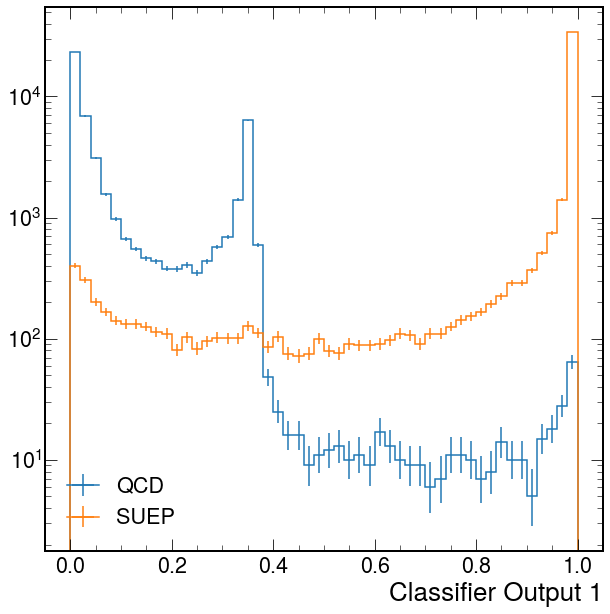

In [43]:
_ = hep.histplot(hist_abcd.project(0), label="QCD")
_ = hep.histplot(hist_abcd_suep.project(0), label="SUEP")
_ = plt.yscale('log')
_ = plt.legend()

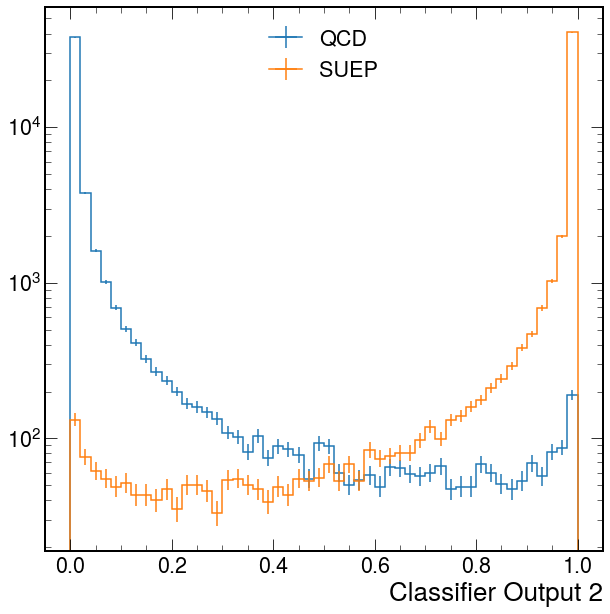

In [44]:
_ = hep.histplot(hist_abcd.project(1), label="QCD")
_ = hep.histplot(hist_abcd_suep.project(1), label="SUEP")
_ = plt.yscale('log')
_ = plt.legend()

In [45]:
ntracks_cut = 0.5j
cl_cut = 0.5j

A = hist_abcd[:ntracks_cut, :cl_cut]
B = hist_abcd[ntracks_cut:, :cl_cut]
C = hist_abcd[:ntracks_cut, cl_cut:]
D = hist_abcd[ntracks_cut:, cl_cut:]
D_exp = C.copy() * B.sum().value / A.sum().value

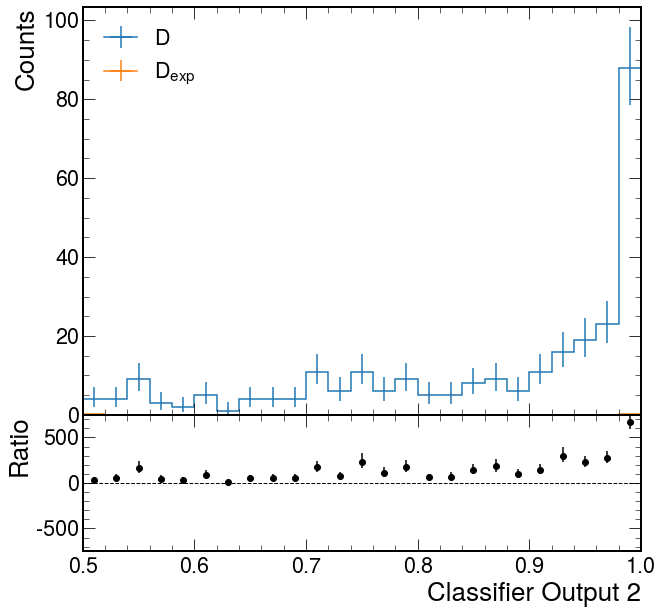

In [46]:
# https://github.com/scikit-hep/hist/blob/main/src/hist/plot.py

D_cl = D[ntracks_cut::sum,cl_cut:]
D_exp_cl = D_exp[:ntracks_cut:sum,cl_cut:]
_ = D_cl.plot_ratio(D_exp_cl,
                    rp_num_label='D',
                    rp_denom_label='$D_{exp}$')